In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, dlla_hw, dlla_p_gradient
from src.dlla.wegener import wegener_t_test_p_gradient, make_mlp_wegener, wegener_p_gradient, class_reduction
from src.tools.lists import random_divide, randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT
from src.tvla.tvla import Tvla

init_plots()

TRACE_LENGTH = 1400

In [2]:
ascad = AscadRandomKey().default

x_prof, y_prof, x_att, y_att = fetch_traces(ascad)

### Model creation

With model hyperparameters to be optimized.

In [3]:

def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [4]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [5]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


0epoch [00:00, ?epoch/s]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [6]:
best_model.predict(x_att[:1])[0]

array([0.00118192, 0.01537843, 0.08366705, 0.19038546, 0.29288867,
       0.24277034, 0.13237543, 0.03696264, 0.00439005], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [7]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

4.227386832237244

In [8]:
dlla_hw(best_model, x_att, y_att)

(0.0, 0.05321061990446031)

### Plot prediction distribution for all traces.

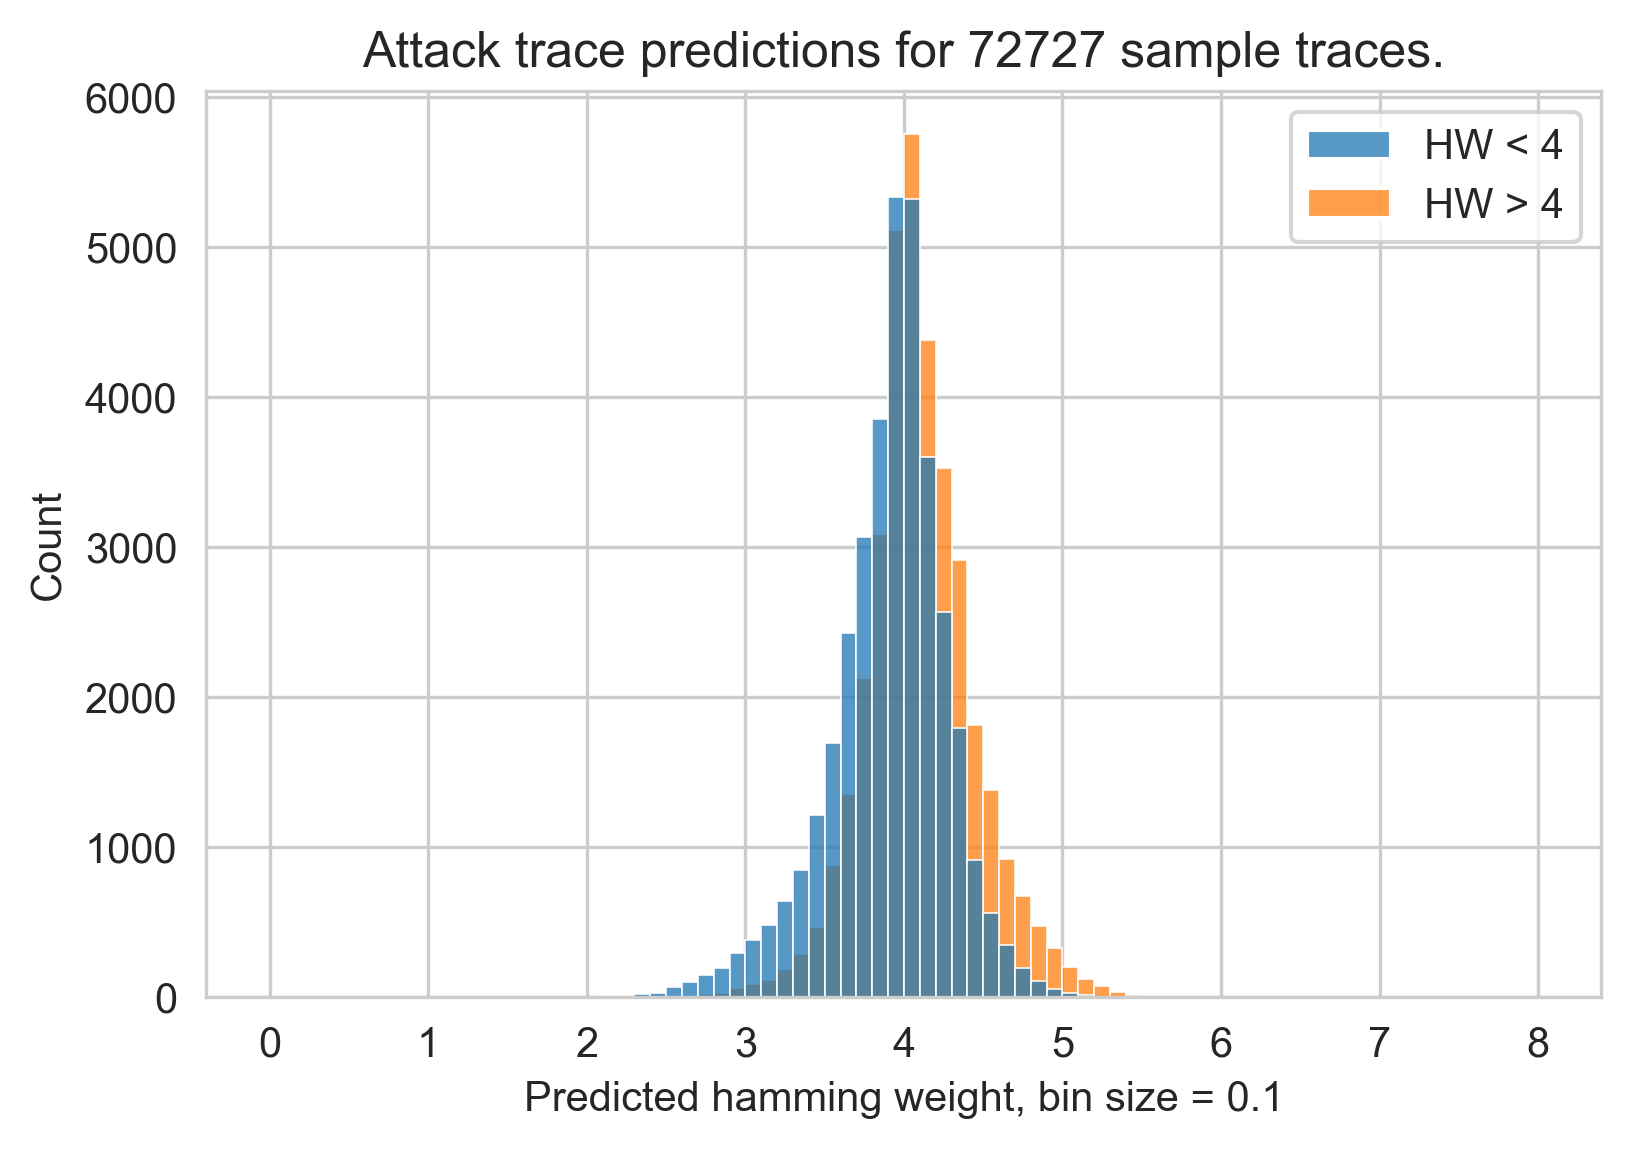

In [9]:
plot_predictions(best_model, x_att, y_att)

### Plot p-gradient.

In [10]:
def split_traces(x, y):
    yam = np.argmax(y, axis=1)
    a = x[np.where(yam < 4)]
    b = x[np.where(yam > 4)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(x_att, y_att)

In [11]:
MAX_LEN = round(len(A_ATT) / 2)
TVLA_AB = Tvla(A_ATT.shape[1])
TVLA_AB.add(A_ATT[:MAX_LEN], B_ATT)
TVLA_BB = Tvla(TRACE_LENGTH)
TVLA_BB.add(*random_divide(B_ATT))

Computing min-p gradients: 100%|██████████| 3/3 [01:40<00:00, 33.37s/it]


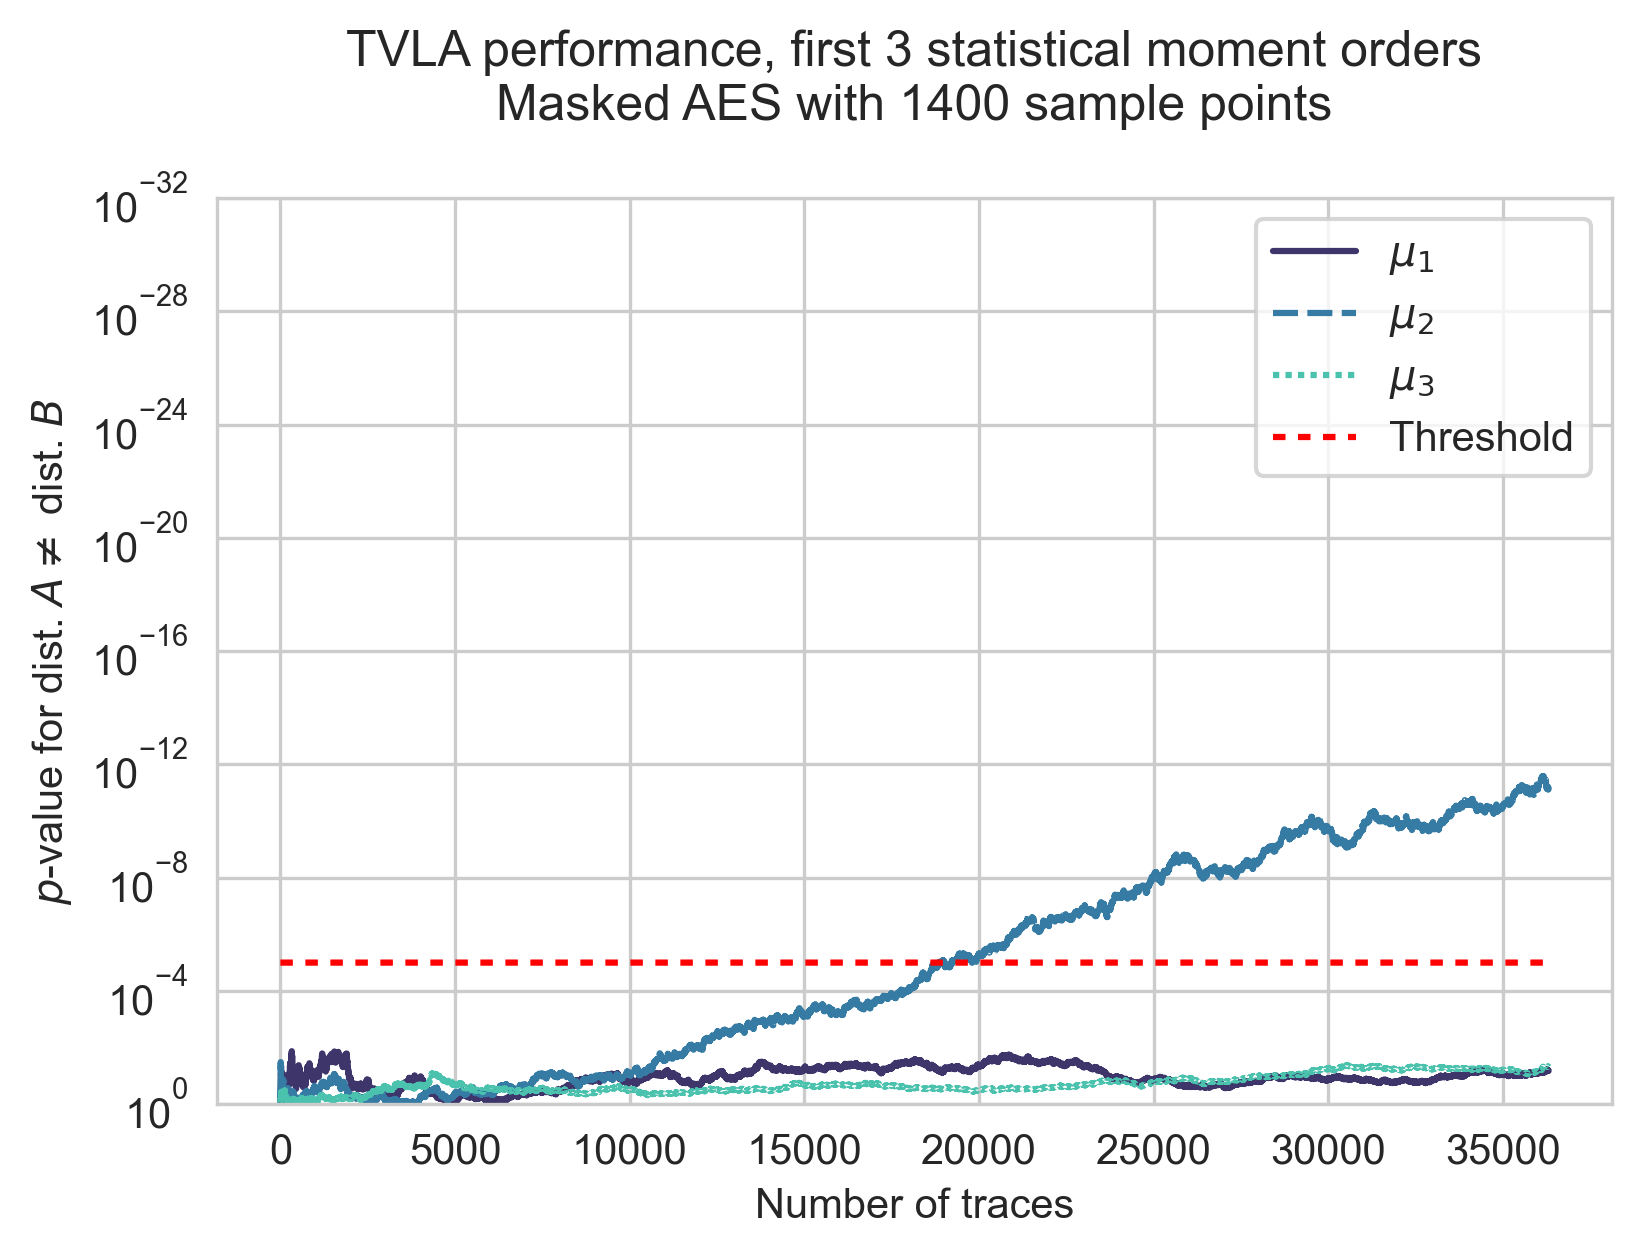

In [12]:
plot_p_gradient(dict([(f"$\\mu_{{{d}}}$", TVLA_AB.p_gradient(d)) for d in range(1, 4)]),
                "TVLA performance, first 3 statistical moment orders\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

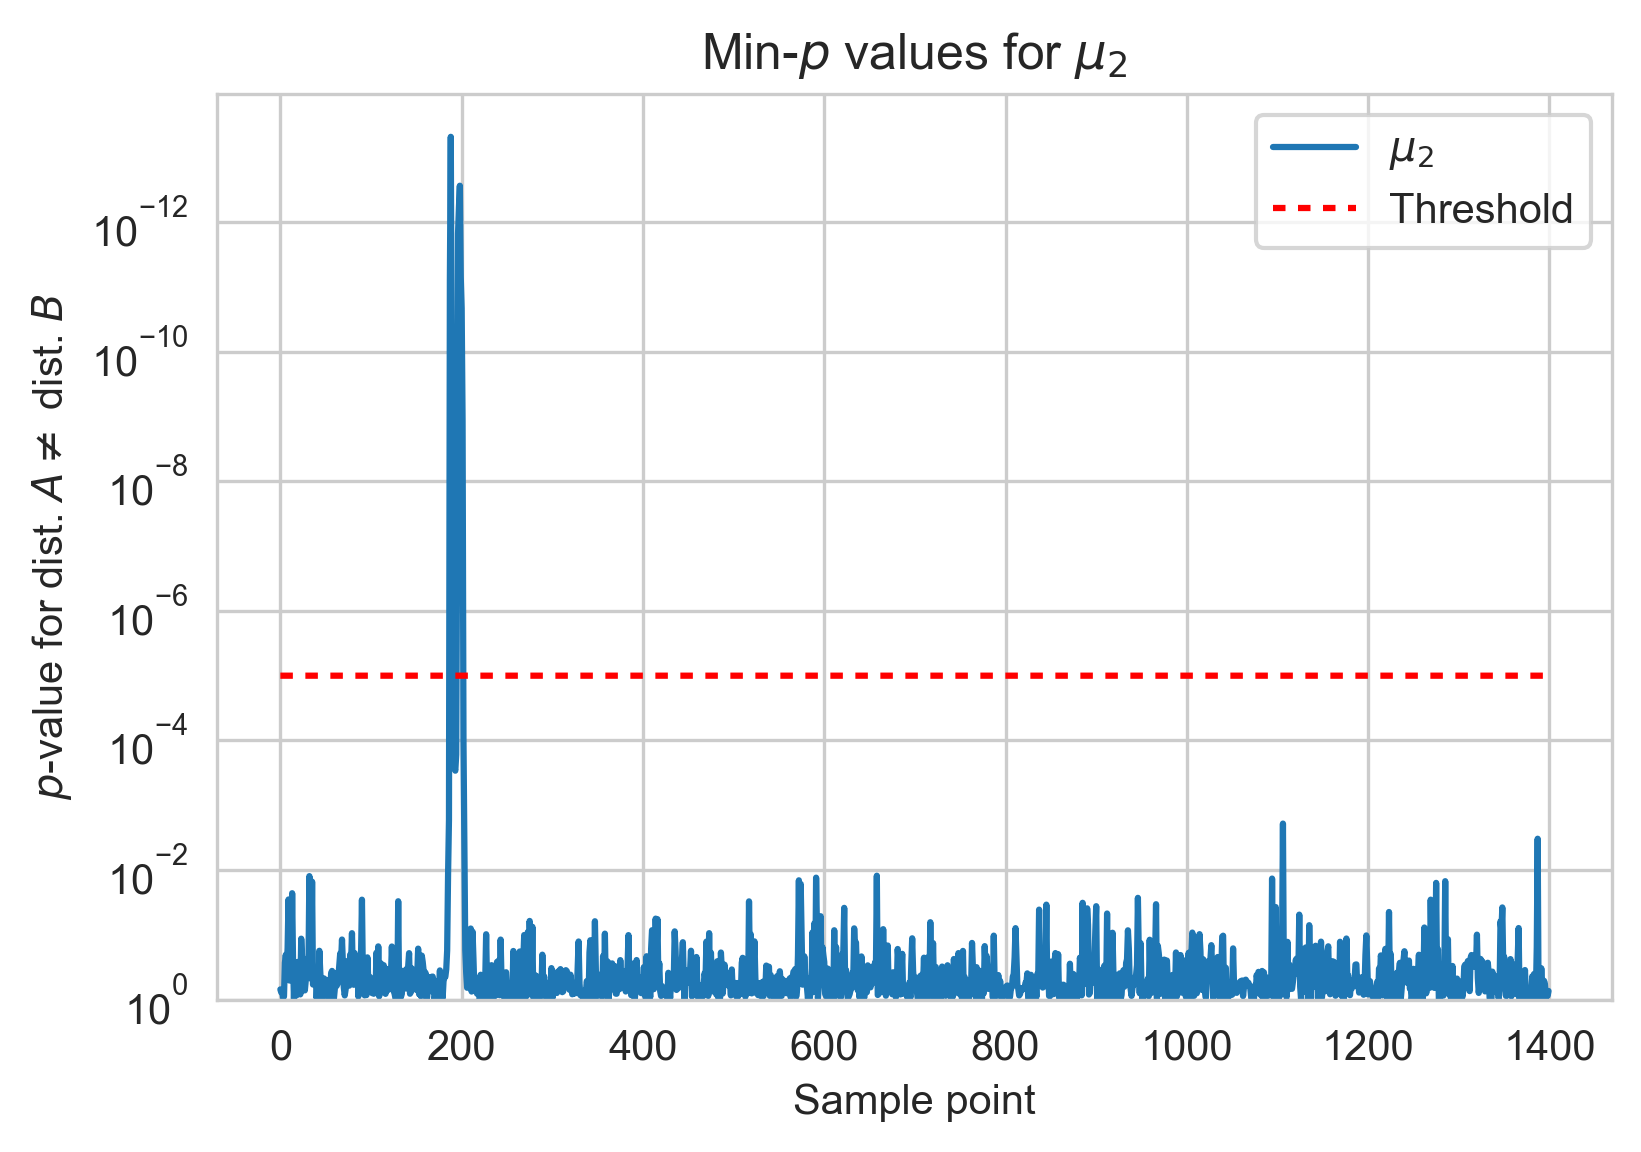

In [13]:
TVLA_AB.plot_min_p(2)

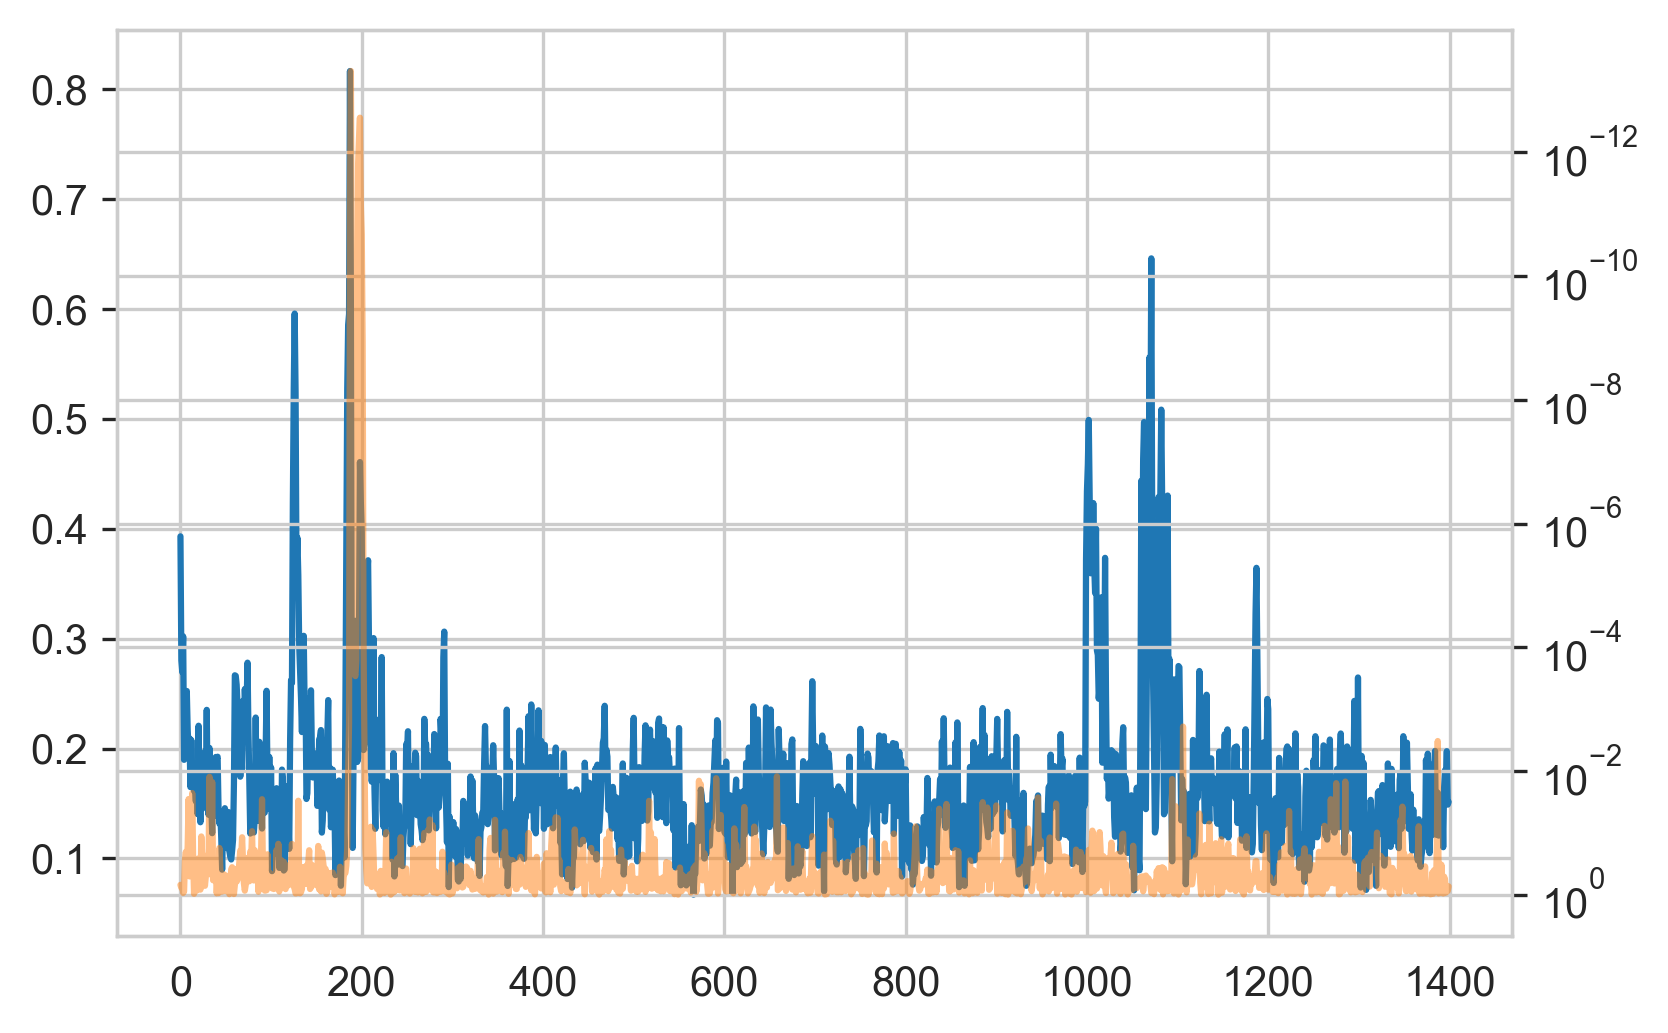

In [14]:
MAX_WEIGHTS = np.max(best_model.layers[0].get_weights()[0], axis=1)

sns.lineplot(data=MAX_WEIGHTS)
AX2 = plt.twinx()
G = sns.lineplot(data=TVLA_AB.min_p[2], ax=AX2, color=sns.color_palette()[1], alpha=.5)
G.set(yscale="log")
G.invert_yaxis()

In [15]:
print("p-value for uncorrelated system producing these datasets")
pearsonr(MAX_WEIGHTS, TVLA_AB.min_p[2])[1]

p-value for uncorrelated system producing these datasets


0.0077989038440535625

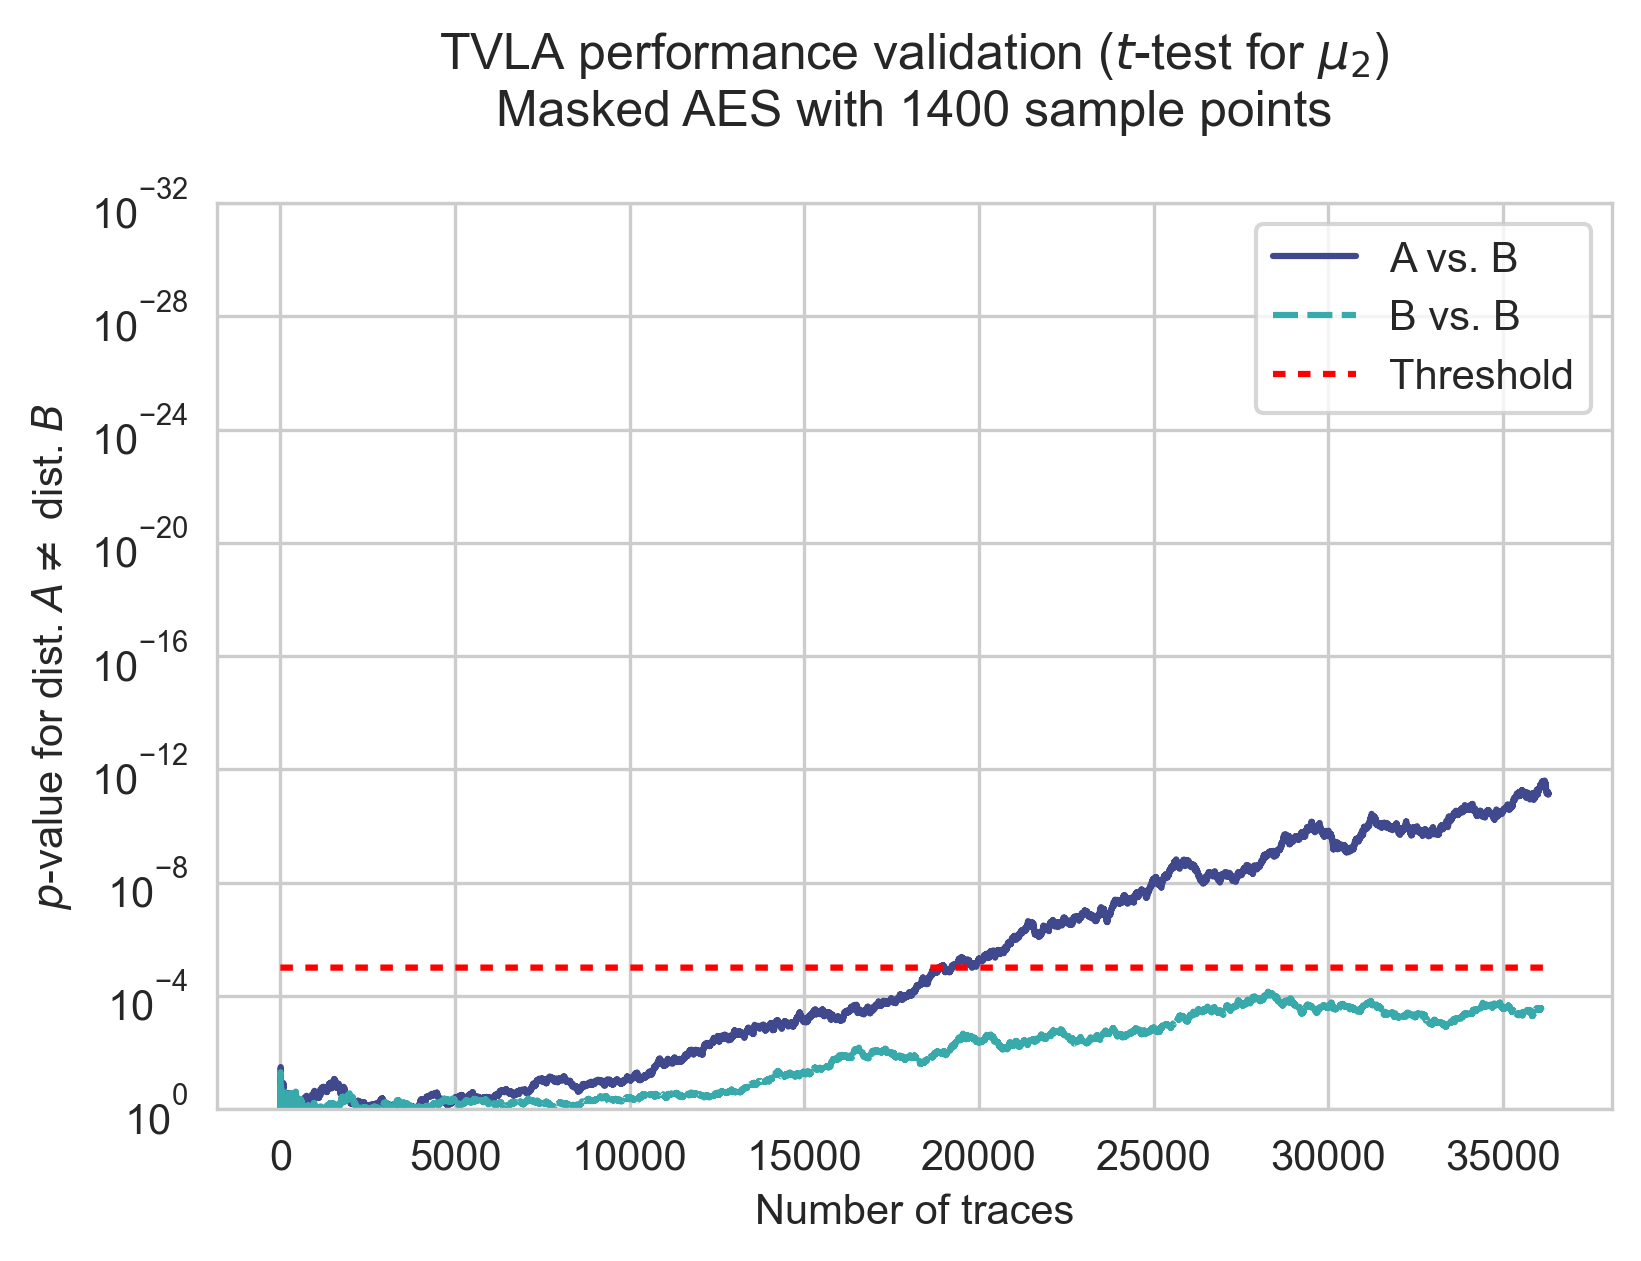

In [16]:
plot_p_gradient({
    "A vs. B": TVLA_AB.p_gradient(2),
    "B vs. B": TVLA_BB.p_gradient(2)
}, "TVLA performance validation ($t$-test for $\\mu_2$)\nMasked AES with 1400 sample points\n",
    palette=PALETTE_GRADIENT,
    file_name="tvla_validation_mu2")

PG_LEN = len(TVLA_AB.p_gradient(2))

In [17]:
PG_DLLA_9 = dlla_p_gradient(best_model, x_att, y_att)["A vs. B"]
PG_DLLA_9_RANDOM = dlla_p_gradient(best_model, x_att, randomize(y_att))["A vs. B"]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


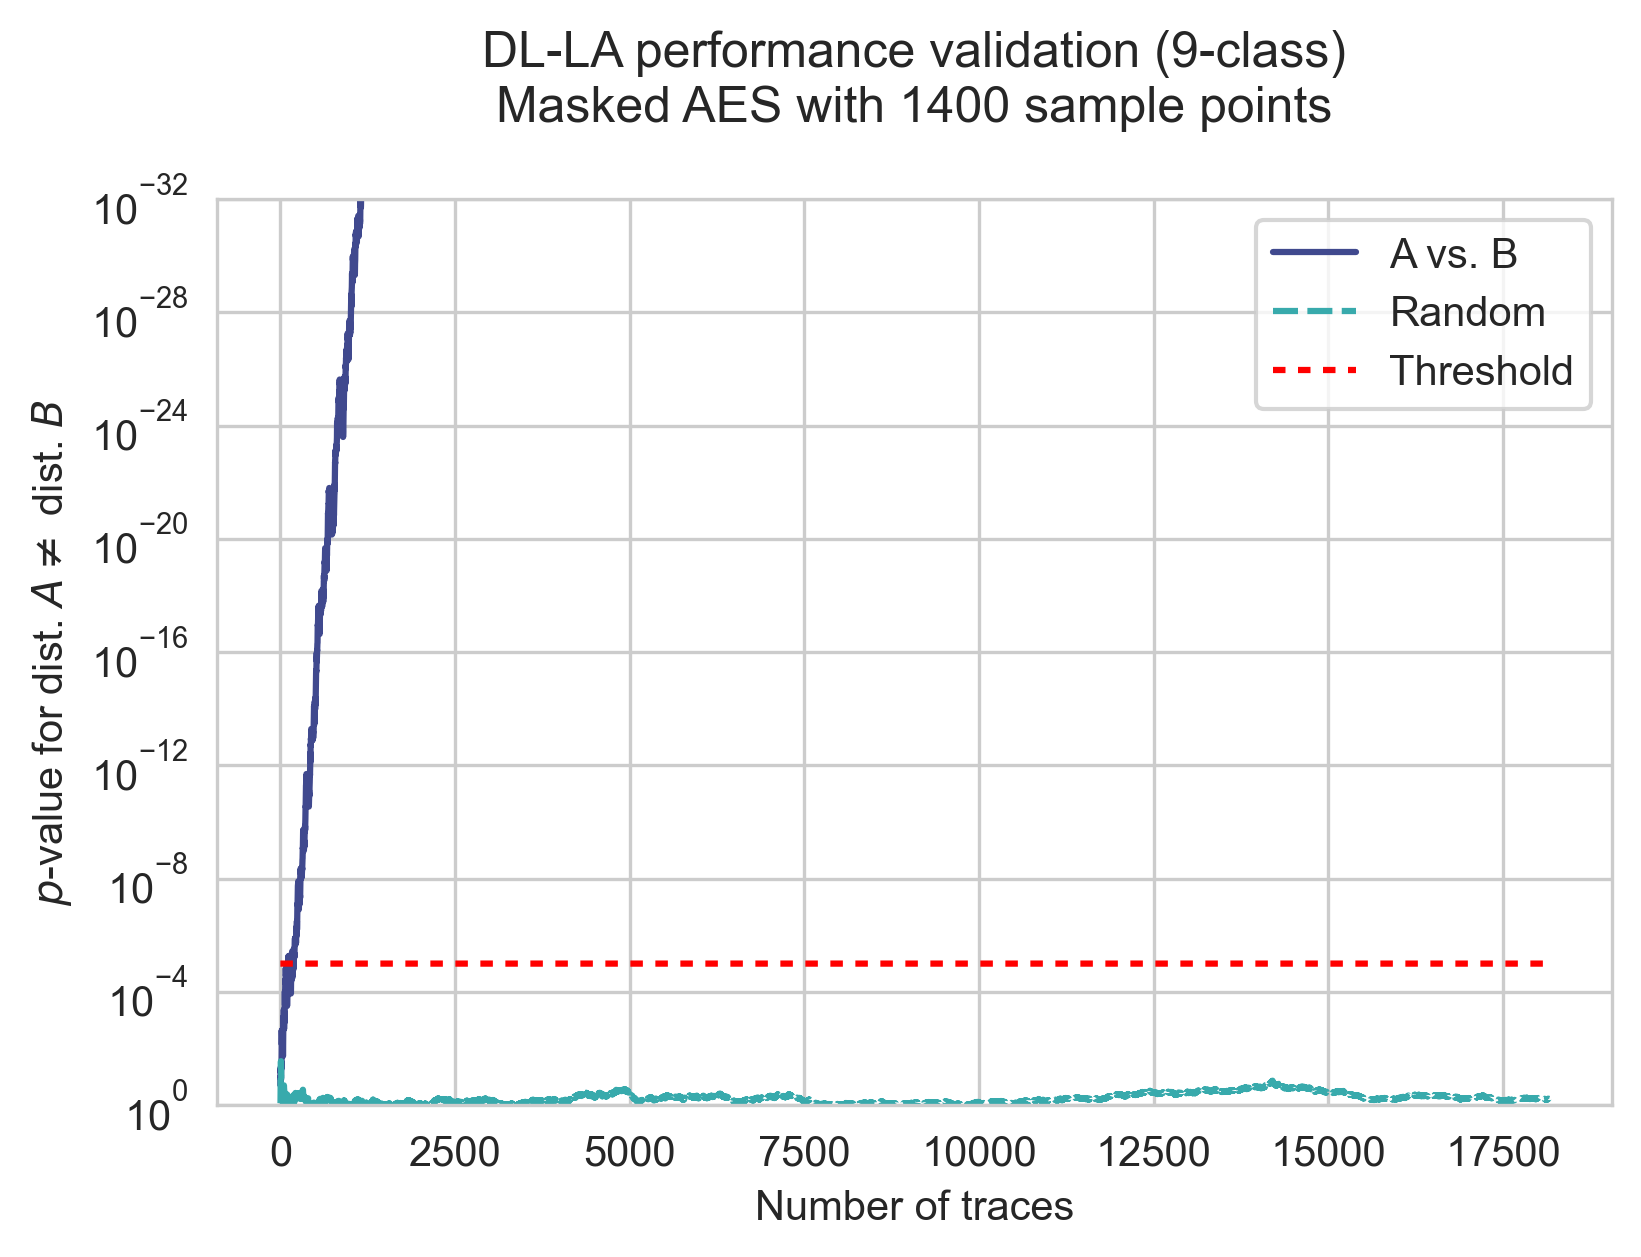

In [18]:
plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "Random": np.array(PG_DLLA_9_RANDOM),
}, "DL-LA performance validation (9-class)\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)


In [19]:
X_PROF_2, Y_PROF_2 = class_reduction(x_prof, y_prof)
X_ATT_2, Y_ATT_2 = class_reduction(x_att, y_att)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

In [20]:
MODEL_WEGENER_AB = make_mlp_wegener(X_PROF_2, Y_PROF_2, X_ATT_2, Y_ATT_2)

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
969/969 [==============================] - 3s 2ms/step - loss: 0.2513 - accuracy: 0.5252 - val_loss: 0.2451 - val_accuracy: 0.5484

In [21]:
PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

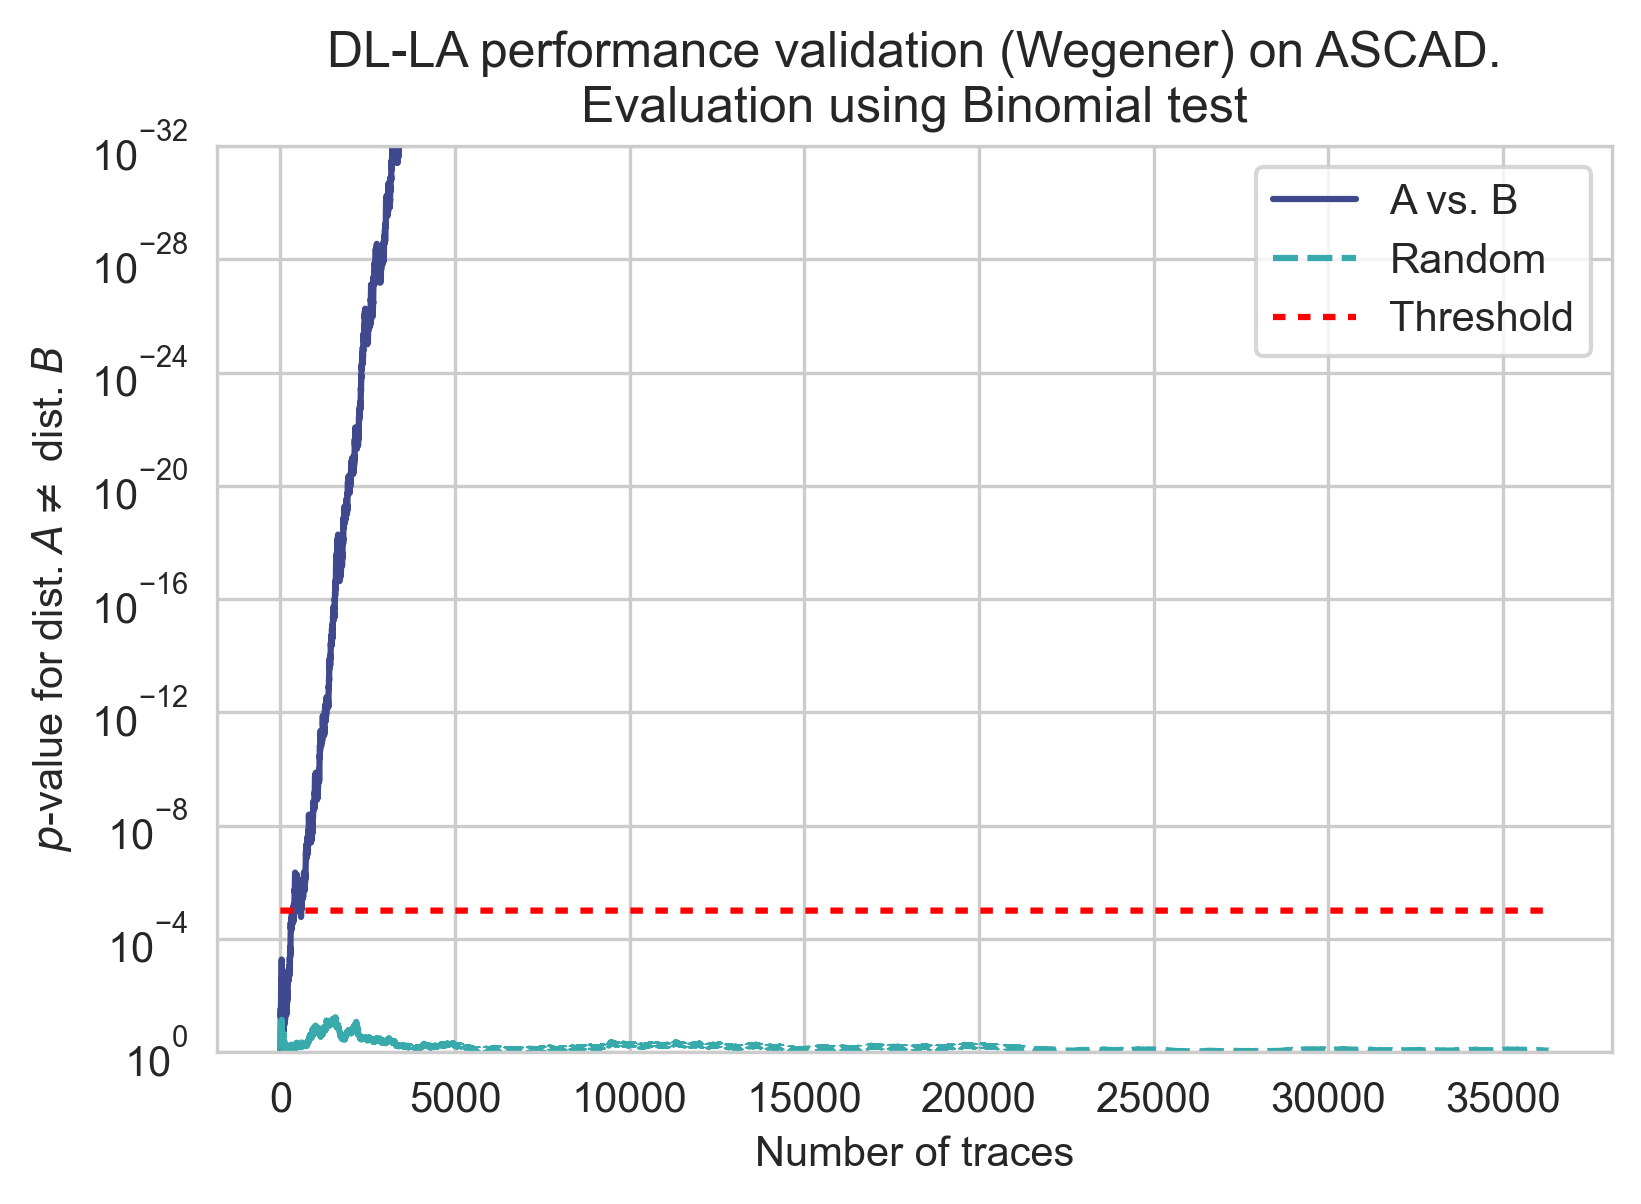

In [22]:
plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "Random": np.array(PG_DLLA_2_RANDOM),
}, "DL-LA performance validation (Wegener) on ASCAD.\nEvaluation using Binomial test", palette=PALETTE_GRADIENT)

In [23]:
PG_DLLA_2_AB_T = wegener_t_test_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
PG_DLLA_2_RANDOM_T = wegener_t_test_p_gradient(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

100%|██████████| 36308/36308 [00:09<00:00, 3975.80it/s]


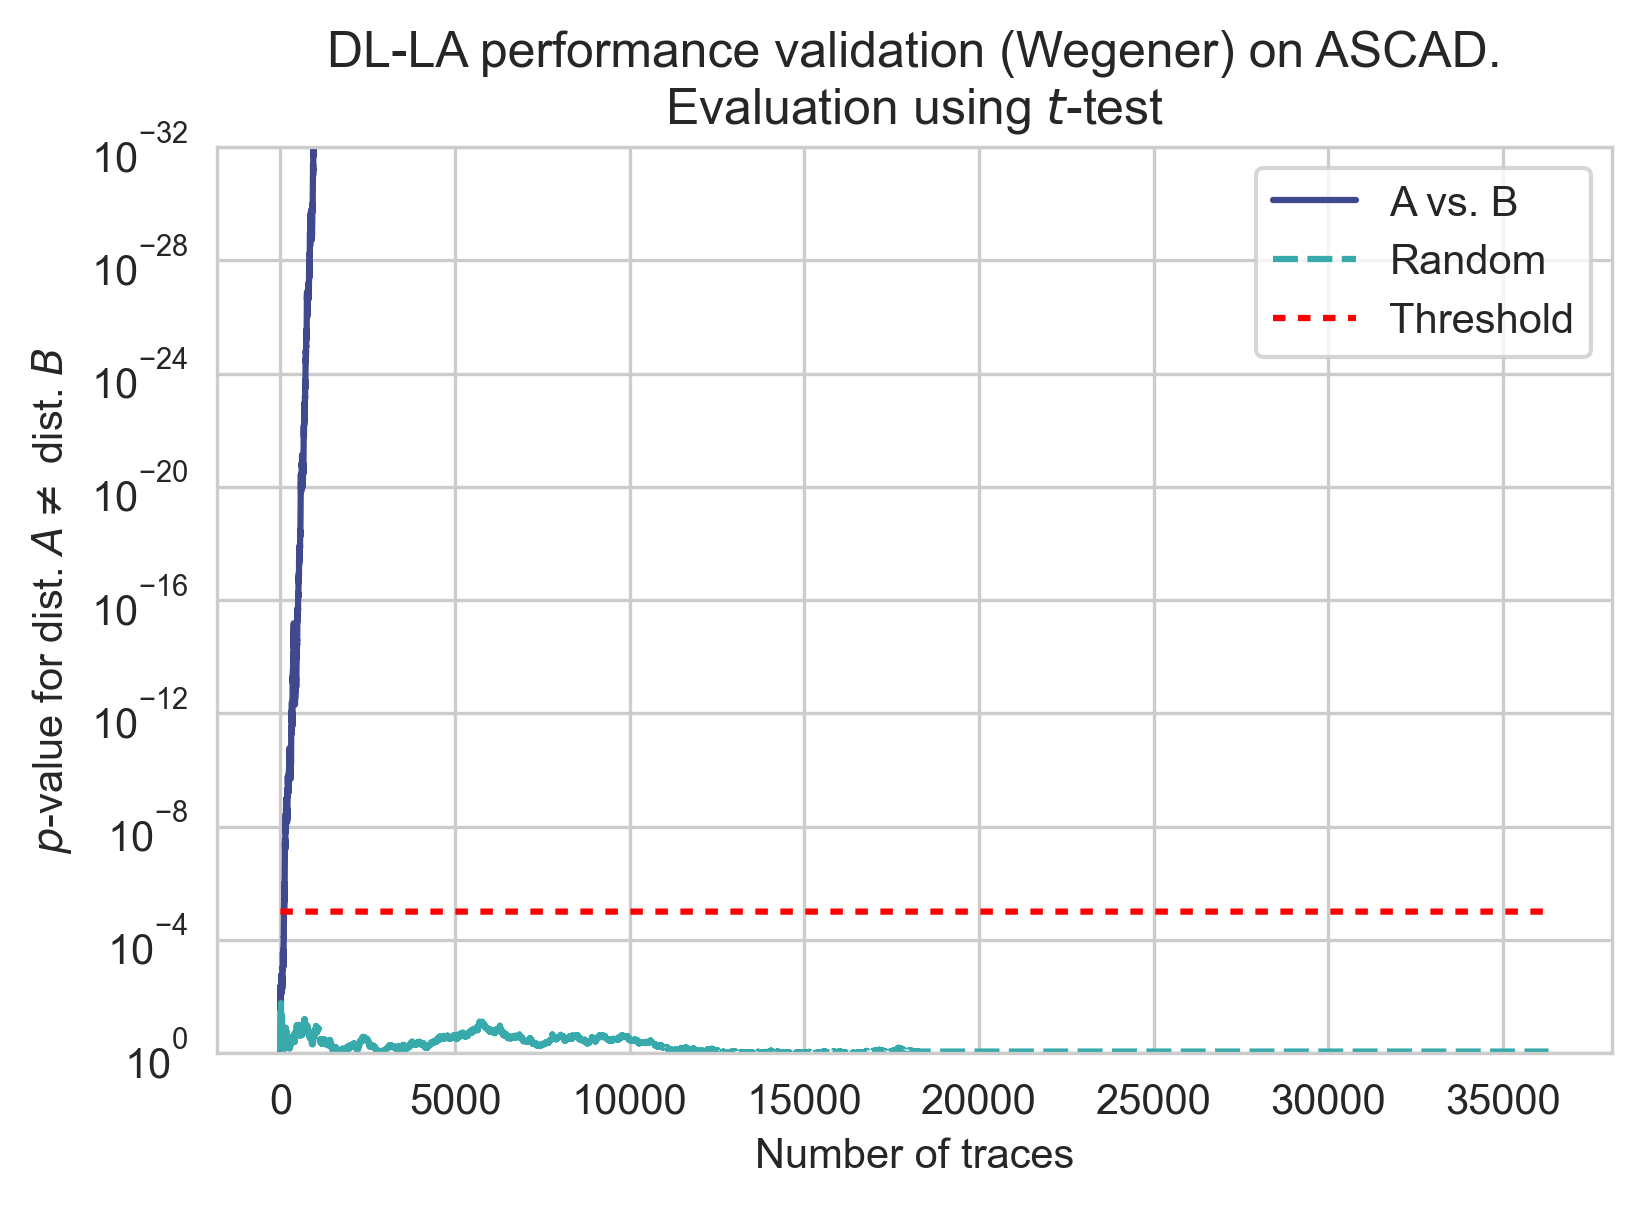

In [24]:
plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB_T),
    "Random": np.array(PG_DLLA_2_RANDOM_T),
}, "DL-LA performance validation (Wegener) on ASCAD.\nEvaluation using $t$-test", palette=PALETTE_GRADIENT)

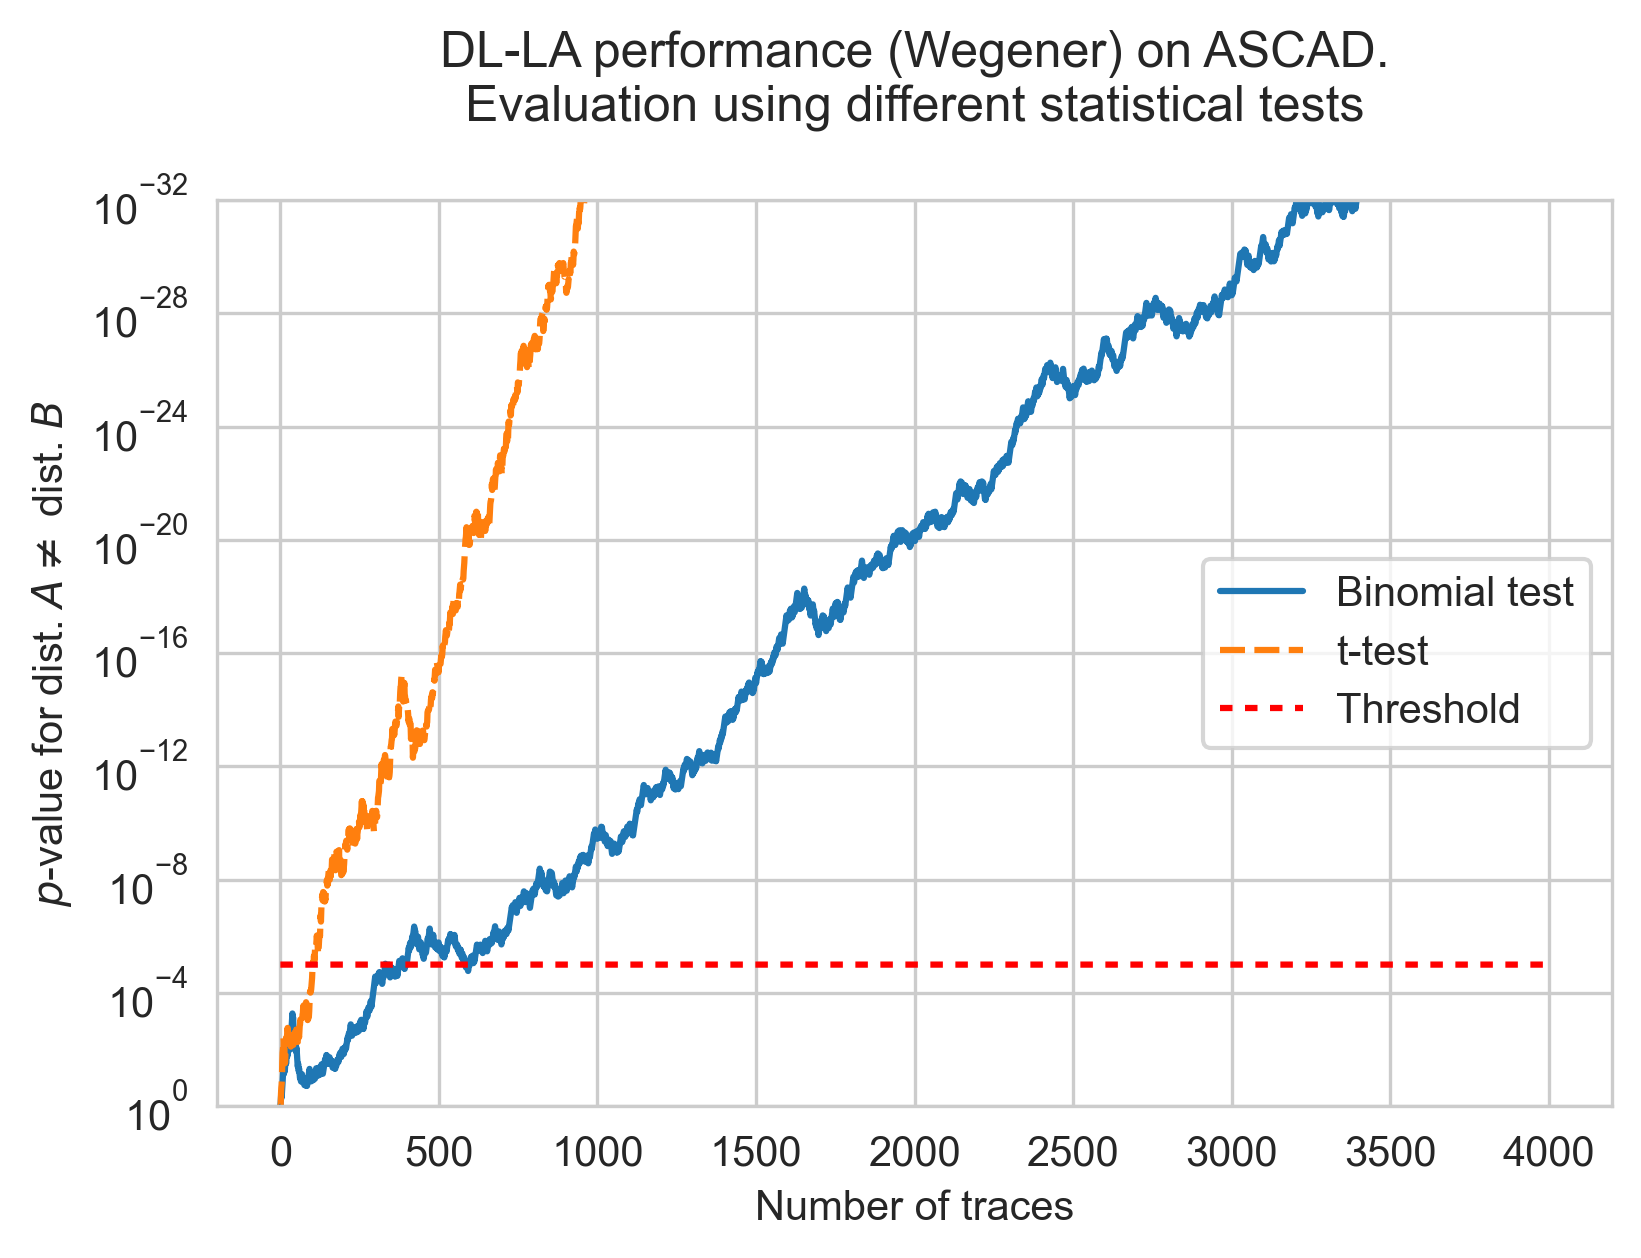

In [25]:
plot_p_gradient({
    "Binomial test": np.array(PG_DLLA_2_AB[:4000]),
    "t-test": np.array(PG_DLLA_2_AB_T[:4000]),
}, "DL-LA performance (Wegener) on ASCAD.\nEvaluation using different statistical tests\n")

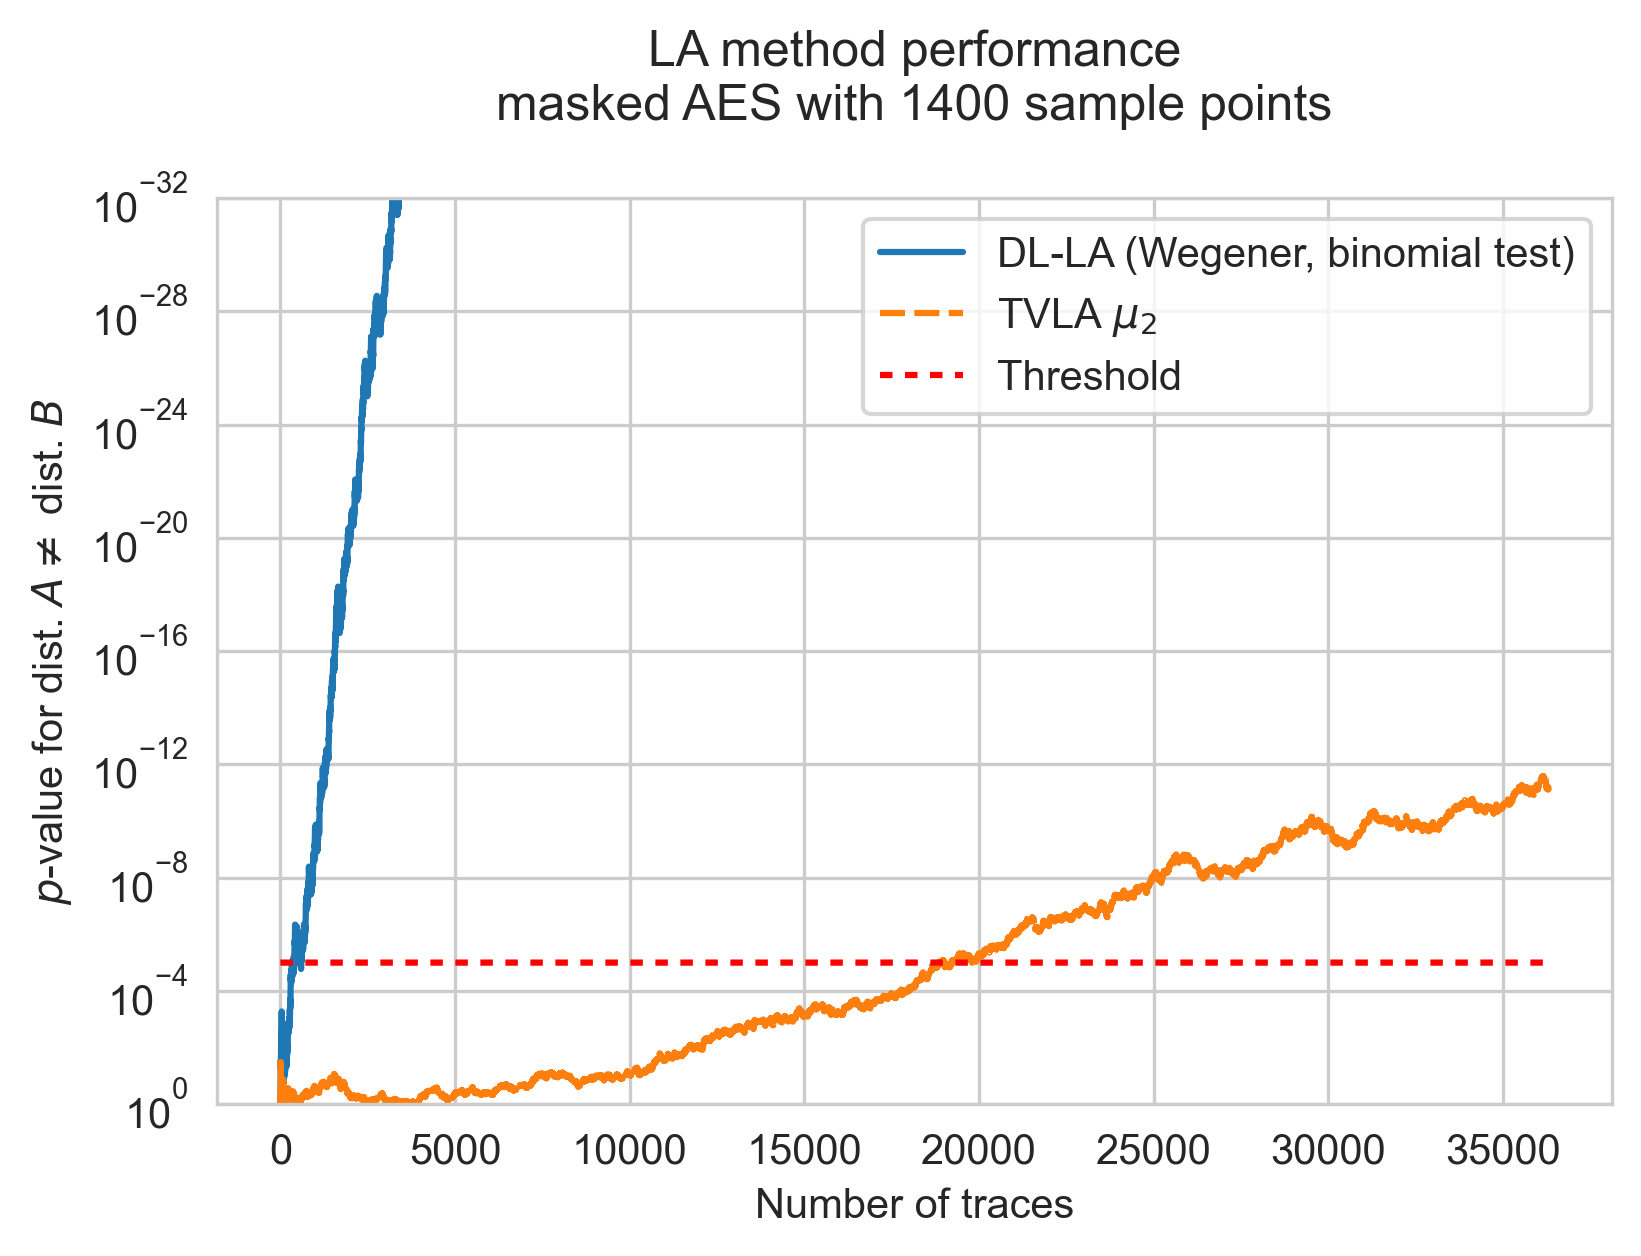

In [26]:
plot_p_gradient({
    "DL-LA (Wegener, binomial test)": np.array(PG_DLLA_2_AB),
    "TVLA $\\mu_2$": TVLA_AB.p_gradient(2)
},"LA method performance\nmasked AES with 1400 sample points\n")

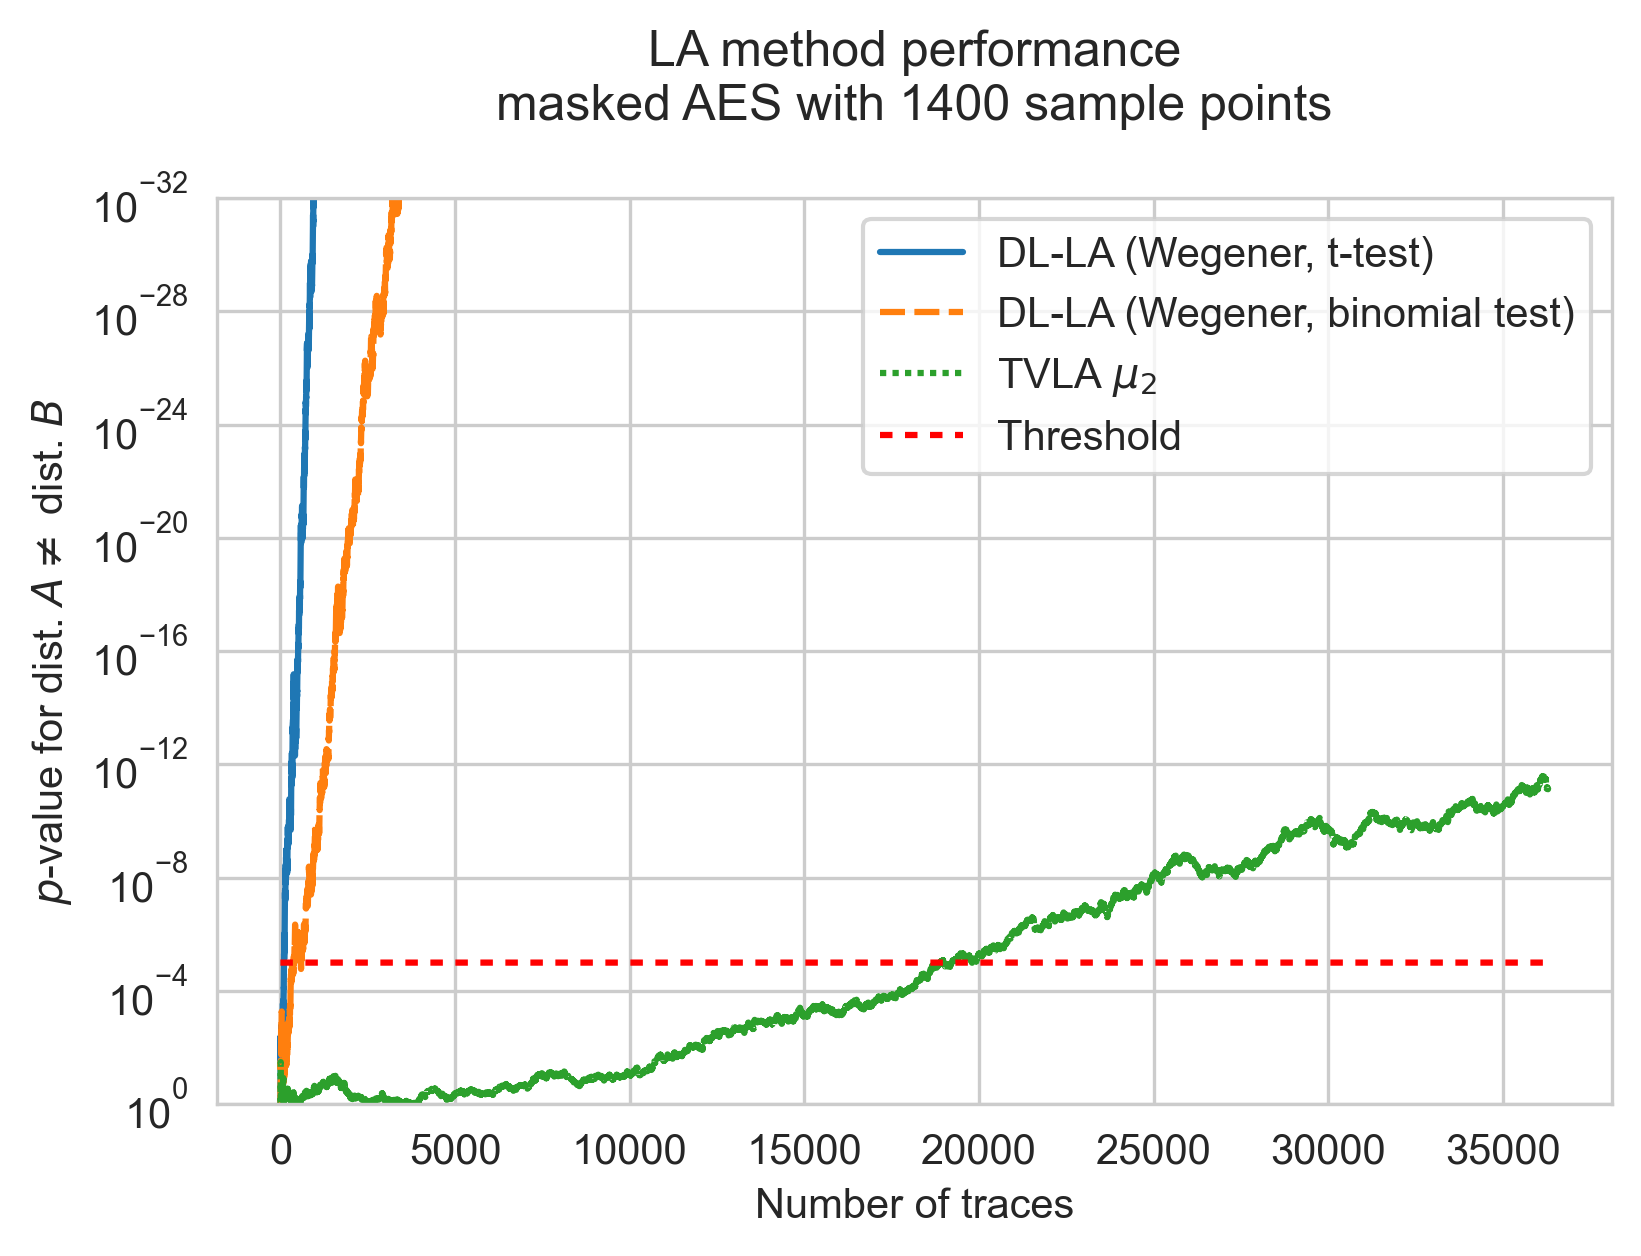

In [27]:
plot_p_gradient({
    "DL-LA (Wegener, t-test)": np.array(PG_DLLA_2_AB_T),
    "DL-LA (Wegener, binomial test)": np.array(PG_DLLA_2_AB),
    "TVLA $\\mu_2$": TVLA_AB.p_gradient(2)
},"LA method performance\nmasked AES with 1400 sample points\n")